In [29]:
def get_cuda_summary():
    import torch
    
    if torch.cuda.is_available():
        print('CUDA device = ', torch.cuda.get_device_name())
        print('Available number of devices = ', torch.cuda.device_count())
        print('Device numbers              = ', list(range(torch.cuda.device_count())))
        print('Current device              = ', torch.cuda.current_device())
        print(torch.cuda.memory_summary())
    else:
        print('cuda is not available')
    

In [30]:
import torch
get_cuda_summary()
torch.cuda.set_device(1)
#do not execute this if you fit auto-pytorch model

CUDA device =  Tesla V100-SXM2-32GB
Available number of devices =  2
Device numbers              =  [0, 1]
Current device              =  0
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| 

## Data Generation
* source : COLAB `robust_multihead-3quantiles.ipynb` 
  - data point = 10000개, 분산이 증가하는 sin 함수
  - `(x,y)` : 표준화 전, `(train_x, train_y)` : 표준화 후

In [31]:
import numpy as np

N = 10000

train_x = np.random.normal(0,1,(N,)) # 표준화 된 값
x = 3*train_x+1

# Cauchy distributed error
s = np.random.standard_cauchy(N)/2

# Laplace distribution
s = np.random.laplace(size=N)

# t-distribution
s = np.random.standard_t(df = 3, size=N)

# Normal distribution
s = np.random.normal(0, 1, N)


#xmean = np.mean(x)
#xsd = np.std(x)

y = train_x/3*s*4 + np.sin(train_x/3*13)*4 + 10

ymean = np.mean(y)
ysd = np.std(y)

xmean = np.mean(x)
xsd = np.std(x)
train_y = (y-ymean)/ysd

In [32]:
%matplotlib inline

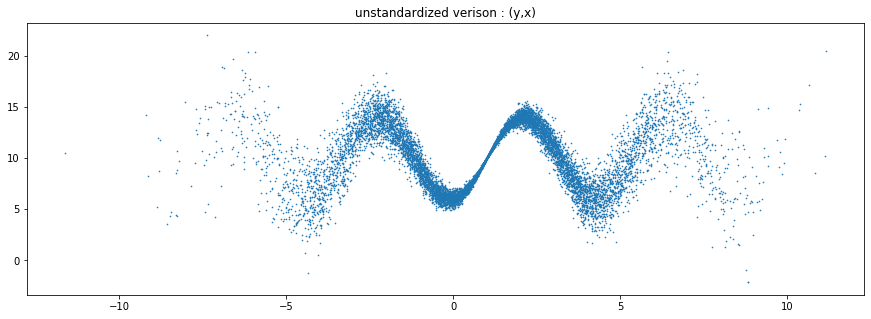

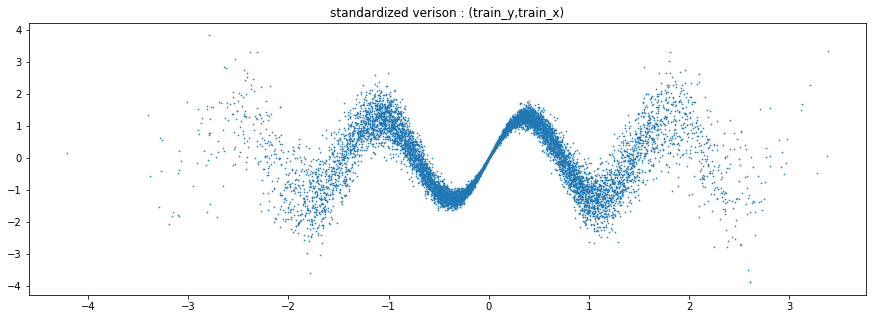

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.scatter(x, y, s=0.4)
plt.title('unstandardized verison : (y,x)')
plt.show()

plt.figure(figsize=(15,5))
plt.scatter(train_x, train_y, s=0.4)
plt.title('standardized verison : (train_y,train_x)')
plt.show()

In [34]:
import pandas as pd

import torch
from torch import nn
import os
import matplotlib.pyplot as plt

#os.environ['KMP_DUPLICATE_LIB_OK']='True'

# data = pd.read_csv('/content/02_Linear_Regression_Model_Data.csv')
# Avoid copy data, just refer
train_x_tr = torch.from_numpy(train_x.reshape([-1,1])).float()#torch.from_numpy(data['x'].values[:1000]).unsqueeze(dim=1).float()
train_y_tr = torch.from_numpy(train_y.reshape([-1,1])).float()#torch.from_numpy(data['y'].values[:1000]).unsqueeze(dim=1).float()


In [35]:
import torch
from torch import nn
from torch.nn.modules.loss import _Loss

class QinputLoss(_Loss):
    # import numpy as np
    import warnings

    __constants__ = ['reduction']

    def __init__(self, size_average=None, reduce=None, reduction='mean', ws=(0,1)):
            # size_average와 reduce는 앞으로 deprecated될 예정, reduction을 사용하라
            # reduction = 'mean' or 'sum' or 'none'
        super(QinputLoss, self).__init__(size_average, reduce, reduction)
        if not(isinstance(ws, tuple)) and not(isinstance(ws, np.ndarray)):
            raise ValueError('ws must be either list or np.array')
        if isinstance(ws, tuple):
            ws = np.array(ws)
        if isinstance(ws, np.ndarray) and not (len(ws.shape) == 1):
            raise ValueError('qs must be shape of 1 dim')

        self.ws = ws

    def forward(self, input, target):
        # 위의 l1_loss에서 따옴
        # l1_loss(input, target, size_average=None, reduce=None, reduction='mean')
        reduction = self.reduction
        #if not torch.jit.is_scripting():  # 뭐 하는 곳인지 모름
        #    raise ValueError('QuantileLoss: torch.jit.is_scripting() not implemented')
        #    #tens_ops = (input, target)
        #    #if any([type(t) is not Tensor for t in tens_ops]) and has_torch_function(tens_ops):
        #    #    return handle_torch_function(
        #    #        l1_loss, tens_ops, input, target, size_average=size_average, reduce=reduce,
        #    #        reduction=reduction)
        if not (target.size() == input.size()):
            warnings.warn("Using a target size ({}) that is different to the input size ({}). "
                          "This will likely lead to incorrect results due to broadcasting. "
                          "Please ensure they have the same size.".format(target.size(), input.size()),
                          stacklevel=2)
            
        ws = torch.tensor(self.ws, dtype = input.dtype, requires_grad=False).to(input.device)
        # ws : weights on quantile loss and weights on output 
        w_q = ws[0]
        w_input = ws[1:].reshape(1,-1)
        q = target[:,0:1]
        #if target.requires_grad: # 아마 target이 고정되어 있는 경우 else:에서 빠른 처리가 가능한 듯.
        if True:
            e_q = torch.abs(target[:,0]-input[:,0]) # q error, if w_q is 0, ignored
            e= target[:,1:] - input[:,1:] # target error
            
            # target[:,0:1] is q!
            ret = w_input*torch.max(q * e, (q - 1) * e)
            #ret = torch.abs(input - target) # MAE 
        if reduction != 'none':
            ret = torch.mean(ret) +torch.mean(w_q* e_q) if reduction == 'mean' else torch.sum(ret) + torch.sum(w_q*e_q)
        else:
            raise ValueError('not(target.requires_grad): not yet implemented')
            #expanded_input, expanded_target = torch.broadcast_tensors(input, target)
            #ret = torch._C._nn.l1_loss(expanded_input, expanded_target, _Reduction.get_enum(reduction))
        return ret 

qil = QinputLoss(ws=(0,1))


In [36]:
# 3-headed output
# modification to MyModel
#    return output1, output2, output3 -> return self.net(x)  # torch.nn.Linear(30,3)
import warnings
class MyModel(torch.nn.Module):
    def __init__(self):
        super(MyModel,self).__init__()
        #self.linear_yq1_output = torch.nn.Linear(30,1)
        #self.linear_yq2_output = torch.nn.Linear(30,1)
        #self.linear_yq3_output = torch.nn.Linear(30,1)

        self.net = torch.nn.Sequential(
        torch.nn.Linear(2, 50),
        torch.nn.LeakyReLU(),
        #torch.nn.Tanh(),
        
        torch.nn.Linear(50, 50),
        torch.nn.LeakyReLU(),
            
        torch.nn.Linear(50,2)

        #torch.nn.Tanh(),
        )

    def forward(self,x):
        return self.net(x)
    
modelD = MyModel()
modelD = modelD.cuda()

optimizer = torch.optim.Adam(params=modelD.parameters(), lr=0.001)

    
train_x_tr = train_x_tr.cuda()    
train_y_tr = train_y_tr.cuda()

for step in range(5000):
    qs = torch.tensor(np.random.uniform(0,1,train_x_tr.shape[0]), dtype=torch.float32).reshape(-1,1).cuda()
    
    output = modelD(torch.cat((qs,train_x_tr), dim=1))
    loss = qil(input=output, target =torch.cat((qs,train_y_tr), dim=1))
    #print(yqs.shape, train_y_tr.shape)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (step+1) % 1000 == 0:
        """
        Show your intermediate results
        """
        print('epoch {} loss={:.4}'.format(step+1, loss.data.item()))
        pass

epoch 1000 loss=0.09747
epoch 2000 loss=0.09665
epoch 3000 loss=0.09579
epoch 4000 loss=0.09666
epoch 5000 loss=0.09553


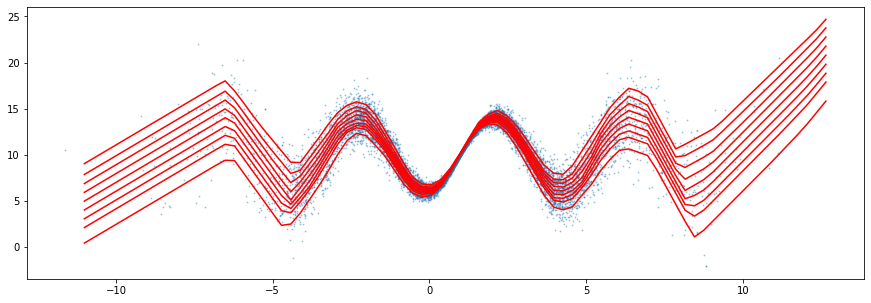

In [37]:
modelD.eval()
plt.figure(figsize=(15,5))
plt.scatter(x, y, s=1, alpha=0.3)

for q in range(1,10,1):


    x_pred = torch.from_numpy(np.arange(-4,4,0.1).reshape([-1,1])).float()#torch.from_numpy(data['x'].values[:1000]).unsqueeze(dim=1).float()
    qs = torch.tensor((q/10)*np.ones(x_pred.shape[0]), dtype=torch.float32).reshape(-1,1).cuda()

    output = modelD(torch.cat((qs,x_pred.cuda()), dim=1))

    y_pred = output[:, 1:]

    x_pred2 = xsd*x_pred+xmean
    y_pred2 = ysd*y_pred+ymean

    yqs = y_pred2.detach().cpu().numpy()

    plt.plot(x_pred2.detach().cpu().numpy(), yqs[:,0], c='r')
